### End to End Evaluation for PVNet
This notebook provides steps to evaluate PVNet on a same dataset that is being used for Mask R-CNN evaluation.

In [2]:
import sys
# Simulated script arguments
sys.argv = ['script_name', '--det', 'example_det', '--type', 'example_type']

In [3]:
from lib.config import cfgs
from cobot_pipeline import make_and_load_pvnet

# Configs/Models in the order 0: mainshell, 1: topshell, 2: insert_mold 
pvnets = tuple([make_and_load_pvnet(c) for c in cfgs])

Load model: data/model/pvnet/mainshell/30.pth
Load model: data/model/pvnet/topshell/50.pth
Load model: data/model/pvnet/insert_mold/25.pth


In [4]:
import os
import json

dataset_path = "/pvnet/data/FIT/end2end"
pvnet_base_dir = os.path.join(dataset_path, "pvnet")
pvnet_annotation_path = os.path.join(pvnet_base_dir, "pvnet.json")

with open(pvnet_annotation_path, 'r') as file:
    pvnet_annotation = json.load(file)
    
# Example of pvnet annotation for each instance
print(pvnet_annotation.keys())
print(pvnet_annotation['0'].keys())
print(pvnet_annotation['0']['instances'][0].keys())
print(pvnet_annotation['0']['instances'][0]['category_id']) #COCO format: 1-mainshell, 2-topshell, 3-insert_mold

dict_keys(['0', '1', '2'])
dict_keys(['camera_K', 'camera_pose_in_world', 'instances'])
dict_keys(['instance_id', 'category_id', 'cropped_rgb', 'cropped_mask', 'uv', 'pose_in_cam', 'pose_in_world'])
3


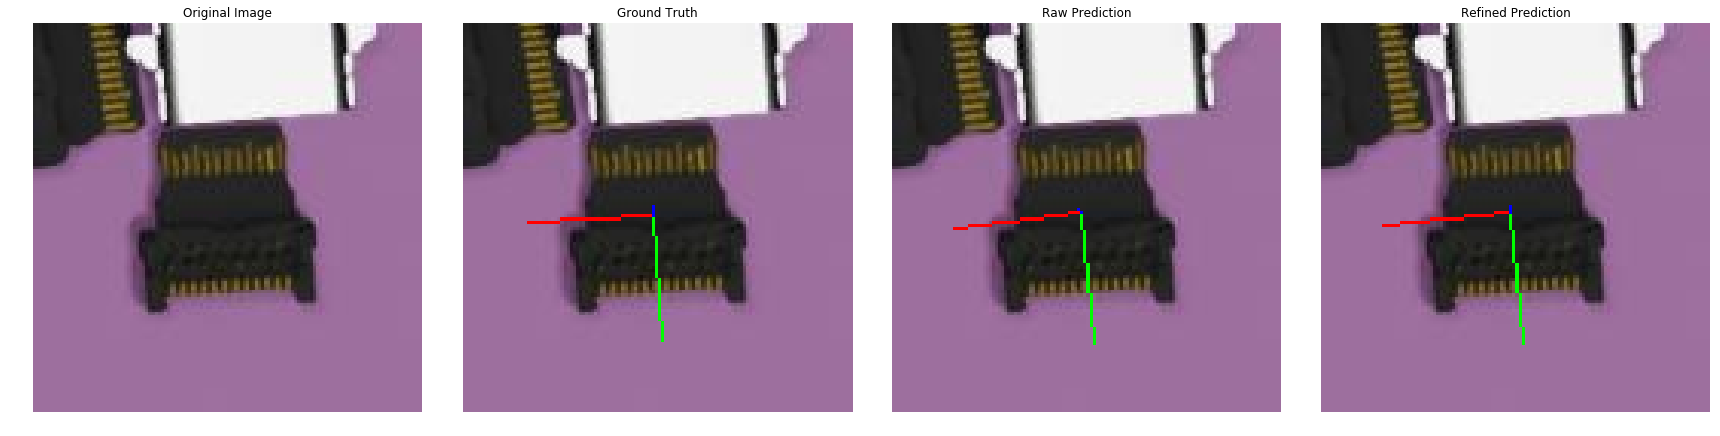

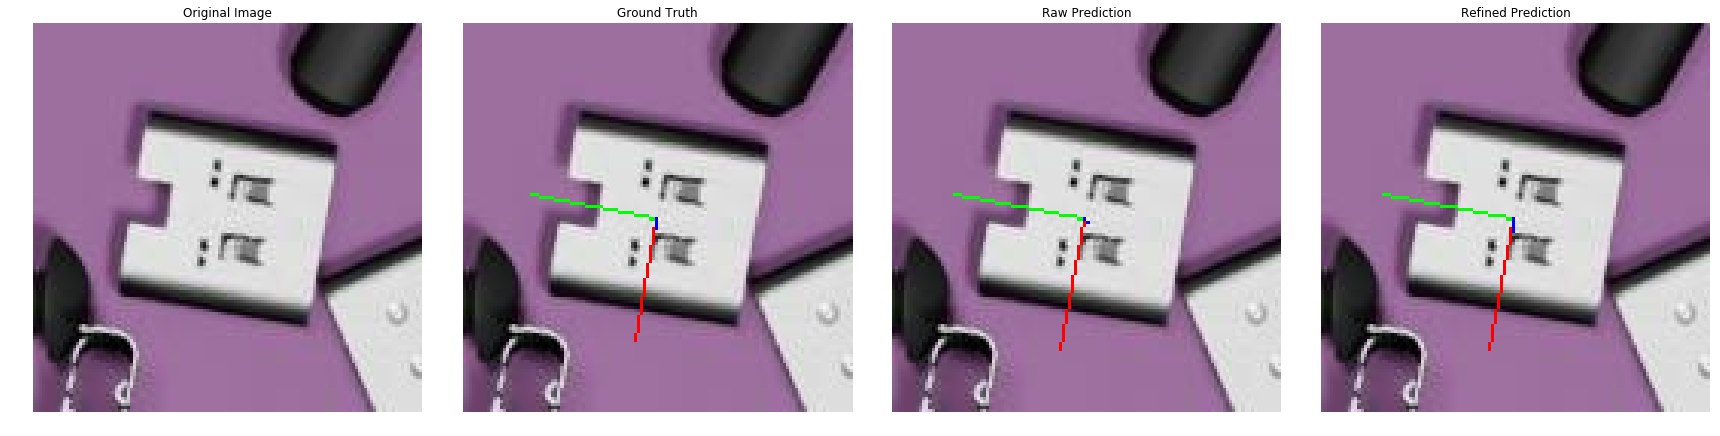

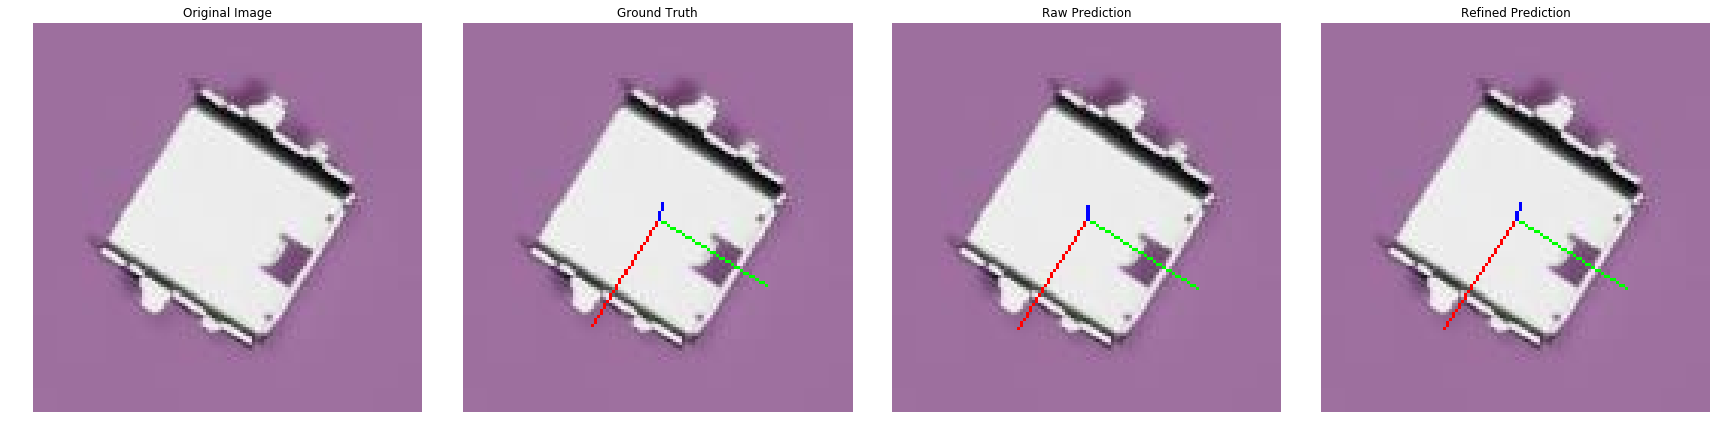

Evaluation Summary
Category: mainshell
  Raw Prediction:
    Translation Error (X): Mean = 1.39 mm, Std = 2.19 mm
    Translation Error (Y): Mean = 1.01 mm, Std = 1.14 mm
    Translation Error (Z): Mean = 101.41 mm, Std = 150.06 mm
    Angular Error (deg): Mean = 16.17, Std = 30.36
    Valid Examples: 21
  Refined Prediction:
    Translation Error (X): Mean = 1.39 mm, Std = 2.19 mm
    Translation Error (Y): Mean = 1.01 mm, Std = 1.14 mm
    Translation Error (Z): Mean = 29.24 mm, Std = 0.95 mm
    Angular Error (deg): Mean = 9.83, Std = 26.44
    Valid Examples: 21
Category: topshell
  Raw Prediction:
    Translation Error (X): Mean = 1.36 mm, Std = 1.17 mm
    Translation Error (Y): Mean = 1.42 mm, Std = 1.04 mm
    Translation Error (Z): Mean = 93.93 mm, Std = 32.80 mm
    Angular Error (deg): Mean = 3.77, Std = 1.84
    Valid Examples: 21
  Refined Prediction:
    Translation Error (X): Mean = 1.36 mm, Std = 1.17 mm
    Translation Error (Y): Mean = 1.42 mm, Std = 1.04 mm
    Trans

In [27]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from lib.datasets.transforms import make_transforms
from lib.utils.pvnet import pvnet_pose_utils
from mrcnn.stable_poses_est import construct_T_stable_from_T_est
from cobot_pvnet import draw_axis

crop_size = 128

class Evaluator:
    def __init__(self, pvnet_annotation, categories, pvnet_models, cfgs, base_dir):
        self.pvnet_annotation = pvnet_annotation
        self.categories = categories
        self.pvnet_models = pvnet_models
        self.cfgs = cfgs
        self.base_dir = base_dir
        self.results = {
            category: {
                "raw": {"translation_error": {"x": [], "y": [], "z": []}, "angular_error": []},
                "refined": {"translation_error": {"x": [], "y": [], "z": []}, "angular_error": []},
                "valid_count": {"raw": 0, "refined": 0},  # Valid example counter
                "visualized": 0,  # Counter for visualized examples
            }
            for category in categories
        }

    def run_inference(self, pvnet, cfg, image, K_cam):
        pvnet.eval()
        transform = make_transforms(cfg, is_train=False)
        processed_image, _, _ = transform(image)
        processed_image = np.array(processed_image).astype(np.float32)

        input_tensor = torch.from_numpy(processed_image).unsqueeze(0).cuda().float()

        with torch.no_grad():
            pvnet_output = pvnet(input_tensor)

        kpt_3d = np.concatenate([cfg.fps_3d, [cfg.center_3d]], axis=0)
        kpt_2d = pvnet_output['kpt_2d'][0].detach().cpu().numpy()
        pose_pred = pvnet_pose_utils.pnp(kpt_3d, kpt_2d, K_cam)

        return np.c_[pose_pred.T, np.array([0, 0, 0, 1])].T

    def compute_errors(self, pose_pred, pose_gt):
        t_pred = pose_pred[:3, 3]
        t_gt = pose_gt[:3, 3]
        translation_error = {
            "x": np.abs(t_pred[0] - t_gt[0]),
            "y": np.abs(t_pred[1] - t_gt[1]),
            "z": np.abs(t_pred[2] - t_gt[2]),
        }

        R_pred = pose_pred[:3, :3]
        R_gt = pose_gt[:3, :3]
        R_diff = R_pred @ R_gt.T
        trace = np.trace(R_diff)
        trace = min(3, max(-1, trace))
        angular_error = np.rad2deg(np.arccos((trace - 1) / 2))

        return translation_error, angular_error

    def add_to_results(self, category, pose_pred, pose_gt, prediction_type):
        translation_error, angular_error = self.compute_errors(pose_pred, pose_gt)

#         if angular_error > 10:
#             return False  # Mark as outlier

        for axis in ["x", "y", "z"]:
            self.results[category][prediction_type]["translation_error"][axis].append(translation_error[axis])
        self.results[category][prediction_type]["angular_error"].append(angular_error)
        self.results[category]["valid_count"][prediction_type] += 1

        return True  # Mark as valid

    def plot_predictions(self, image_rgb, gt, raw_prediction, refined_prediction, K):
        gt_img_overlay = draw_axis(image_rgb, gt[:3, :3], gt[:3, 3], K)
        raw_img_overlay = draw_axis(image_rgb, raw_prediction[:3, :3], raw_prediction[:3, 3], K)
#         refined_img_overlay = draw_axis(image_rgb, refined_prediction[:3, :3], refined_prediction[:3, 3], K)
        # For the purpose of visualization, make sure the origin doesn't shift away from center of object
        refined_img_overlay = draw_axis(image_rgb, refined_prediction[:3, :3], raw_prediction[:3, 3], K)

        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        axes[0].imshow(image_rgb)
        axes[0].axis("off")
        axes[0].set_title("Original Image")

        axes[1].imshow(gt_img_overlay)
        axes[1].axis("off")
        axes[1].set_title("Ground Truth")
        
        axes[2].imshow(raw_img_overlay)
        axes[2].axis("off")
        axes[2].set_title("Raw Prediction")

        axes[3].imshow(refined_img_overlay)
        axes[3].axis("off")
        axes[3].set_title("Refined Prediction")
        plt.tight_layout()
        plt.show()

    def evaluate(self):
        for image_id, image_data in self.pvnet_annotation.items():
            camera_K = np.array(image_data['camera_K'])
            camera_pose_in_world = np.array(image_data['camera_pose_in_world'])

            for instance in image_data['instances']:
                category_id = instance["category_id"]
                category = self.categories[category_id - 1]
                cropped_rgb_path = os.path.join(self.base_dir, instance["cropped_rgb"])
                if not os.path.exists(cropped_rgb_path):
                    print(f"Image path does not exist: {cropped_rgb_path}")
                    continue

                image = cv2.imread(cropped_rgb_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                K = camera_K.copy()
                uv = instance["uv"]
                K[0, 2] += crop_size // 2 - uv[0]
                K[1, 2] += crop_size // 2 - uv[1]

                pose_gt = np.array(instance["pose_in_cam"])
                raw_prediction = self.run_inference(self.pvnet_models[category_id - 1], self.cfgs[category_id - 1], image_rgb, K)

                T_cam_in_world = camera_pose_in_world.copy()
                T_pred_in_world = T_cam_in_world @ raw_prediction
                T_stable_in_world = construct_T_stable_from_T_est(T_pred_in_world, category_id - 1)
                refined_prediction = np.linalg.inv(T_cam_in_world) @ T_stable_in_world
                refined_prediction[0, 3] = raw_prediction[0, 3]
                refined_prediction[1, 3] = raw_prediction[1, 3]

                raw_valid = self.add_to_results(category, raw_prediction, pose_gt, prediction_type="raw")
                refined_valid = self.add_to_results(category, refined_prediction, pose_gt, prediction_type="refined")

                if refined_valid and self.results[category]["visualized"] < 1:
                    self.plot_predictions(image_rgb, pose_gt, raw_prediction, refined_prediction, K)
                    self.results[category]["visualized"] += 1

    def summarize(self):
        print("=" * 70)
        print("Evaluation Summary")
        print("=" * 70)

        for category, stats in self.results.items():
            print(f"Category: {category}")
            for pred_type, results in stats.items():
                if pred_type in ["valid_count", "visualized"]:
                    continue
                trans_errors = results["translation_error"]
                angular_errors = np.array(results["angular_error"])

                if len(trans_errors["x"]) > 0:
                    trans_means = {axis: np.mean(np.array(trans_errors[axis]) * 1000) for axis in ["x", "y", "z"]}
                    trans_stds = {axis: np.std(np.array(trans_errors[axis]) * 1000) for axis in ["x", "y", "z"]}
                    angular_mean = np.mean(angular_errors)
                    angular_std = np.std(angular_errors)

                    print(f"  {pred_type.capitalize()} Prediction:")
                    for axis in ["x", "y", "z"]:
                        print(f"    Translation Error ({axis.upper()}): Mean = {trans_means[axis]:.2f} mm, Std = {trans_stds[axis]:.2f} mm")
                    print(f"    Angular Error (deg): Mean = {angular_mean:.2f}, Std = {angular_std:.2f}")
                    print(f"    Valid Examples: {stats['valid_count'][pred_type]}")
                else:
                    print(f"  {pred_type.capitalize()} Prediction: No valid instances.")


categories = ["mainshell", "topshell", "insert_mold"]
evaluator = Evaluator(pvnet_annotation, categories, pvnets, cfgs, pvnet_base_dir)
evaluator.evaluate()
evaluator.summarize()

### Sanity Check of pose annotation

Image Path: /pvnet/data/FIT/end2end/pvnet/0/cropped_rgb/3.jpg


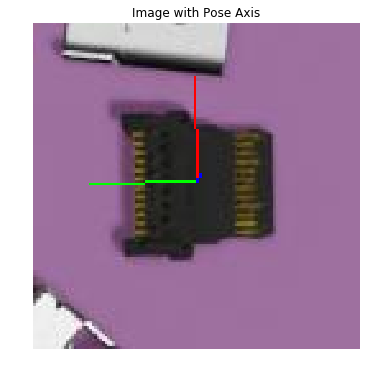

In [20]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from cobot_pvnet import draw_axis

def sanity_check_visualization(pvnet_base_dir, pvnet_annotation, instance_idx=10, crop_size=128):
    """
    Perform a sanity check for visualization of cropped images and overlayed axes.
    
    Args:
    - pvnet_base_dir (str): Base directory of the PVNet dataset.
    - pvnet_annotation (dict): Annotation dictionary containing pose and camera information.
    - instance_idx (int): Index of the instance to visualize.
    - crop_size (int): Size of the crop for visualization.
    """
    # Load the cropped RGB image
    rgb_img_path = os.path.join(pvnet_base_dir, pvnet_annotation['0']['instances'][instance_idx]['cropped_rgb'])
    print(f"Image Path: {rgb_img_path}")
    image = cv2.imread(rgb_img_path)
    
    # Ensure the image is loaded
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {rgb_img_path}")
    
    # Convert the image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Extract transformation and projection details
    T = np.array(pvnet_annotation['0']['instances'][instance_idx]['pose_in_cam'])
    uv = np.array(pvnet_annotation['0']['instances'][instance_idx]['uv'])
    K_cam = np.array(pvnet_annotation['0']['camera_K'])
    
    # Adjust the intrinsic camera matrix for cropping
    K = K_cam.copy()
    K[0, 2] += crop_size // 2 - uv[0]
    K[1, 2] += crop_size // 2 - uv[1]
    
    # Draw the axis on the image
    img_axis = draw_axis(image_rgb, T[:3, :3], T[:3, 3], K)
    
    # Display the image with the overlayed axes
    plt.figure(figsize=(8, 6))
    plt.imshow(img_axis)
    plt.axis('off')
    plt.title("Image with Pose Axis")
    plt.show()

# Example usage
sanity_check_visualization(pvnet_base_dir, pvnet_annotation, instance_idx=2)